# iPRules

# Statics

In [11]:
import dask.dataframe as dd
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import metrics


## Load Dataset

In [12]:

from notebooks.IPRules.read_datasets import read_dataset

filename = "kr-vs-kp"
filename = "divorce"

path = f'../..'
dataset_path_name = f'{path}/data/{filename}.csv'
X, y, dataset, target_value_name, pandas_dataset = read_dataset(filename, dataset_path_name)

pandas_dataset.head()

,Atr1_0,Atr1_1,Atr1_2,Atr1_3,Atr1_4,Atr2_0,Atr2_1,Atr2_2,Atr2_3,Atr2_4,...,Atr53_1,Atr53_2,Atr53_3,Atr53_4,Atr54_0,Atr54_1,Atr54_2,Atr54_3,Atr54_4,Class
0,False,False,True,False,False,False,False,True,False,False,...,False,True,False,False,False,True,False,False,False,True
1,False,False,False,False,True,False,False,False,False,True,...,False,True,False,False,False,False,True,False,False,True
2,False,False,True,False,False,False,False,True,False,False,...,False,True,False,False,False,False,True,False,False,True
3,False,False,False,True,False,False,False,True,False,False,...,False,True,False,False,False,False,True,False,False,True
4,False,False,True,False,False,False,False,True,False,False,...,True,False,False,False,True,False,False,False,False,True


In [13]:
#Define dataset
X_train, X_test, y_train, y_test = train_test_split(dataset.data, dataset.target, test_size=0.2, random_state=1)
encoded_train_pandas_dataset = pd.DataFrame(data= np.c_[X_train, y_train], columns= list(dataset['feature_names']) + [target_value_name])
encoded_test_pandas_dataset = pd.DataFrame(data= np.c_[X_test, y_test], columns= list(dataset['feature_names']) + [target_value_name])
print('Sizes (without target):')
print(f'Original size {dataset.data.shape}')
print(f'Train size {X_train.shape}')
print(f'Test size {X_test.shape}')
print(f'encoded_train_pandas_dataset size {encoded_train_pandas_dataset.shape}')
print(f'encoded_test_pandas_dataset size {encoded_test_pandas_dataset.shape}')

Sizes (without target):
Original size (170, 270)
Train size (136, 270)
Test size (34, 270)
encoded_train_pandas_dataset size (136, 271)
encoded_test_pandas_dataset size (34, 271)


## Define Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, make_scorer, recall_score, accuracy_score

# Define scorer
ensemble = RandomForestClassifier(n_estimators=100, criterion="gini")
ensemble.fit(X_train, y_train)

RandomForestClassifier()

## iPRules

->Extract feature importance list


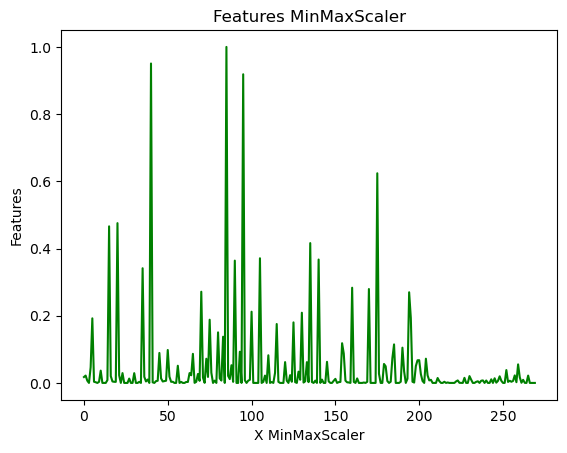

	 Original features 270
	 Selected features 90
	 Percentage of selected rules: 33.333333333333336 %
->Generate new tree based on list
Elapsed time to compute the binary_tree_generator: 968.440 seconds
->Generate obtained patterns tree
Elapsed time to compute the obtain_pattern_list_of_valid_nodes_with_pvalue: 1.491 seconds
->Categorize patterns
Elapsed time to compute the categorize_patterns: 0.052 seconds
->Prune Rules
Elapsed time to compute the prune_rules: 0.000 seconds


In [15]:
from iPRules.iPRules import iPRules

rules = iPRules(
                feature_names=dataset.feature_names,
                target_value_name = dataset.target_names,
                display_features = True,
                display_logs = True,
                chi_square_percent_point_function = 0.95,
                scale_feature_coefficient = 0.01,
                min_accuracy_coefficient = 0.95,
                min_number_class_per_node = 1
            )
# Fit model
rules.fit(encoded_train_pandas_dataset, ensemble.feature_importances_)

# Print Model

In [16]:
print(rules)

> ++++++++++++++++++++++++++++
> iPRules --  Number of Rules 8:
> iPRules --  Number of Minimal Rules 8:
> ++++++++++++++++++++++++++++
> ------------------------------
 ** Target value: True ** Target: 68 ** Total: 75 ** Accuracy: 0.9066666666666666 ** Complexity: 1 ** Chi2 critical_value: 3.841458820694124 ** P_value: 5.251466273625324e-25
	 Query: Atr18_0 == False
> ------------------------------
> ------------------------------
 ** Target value: False ** Target: 60 ** Total: 61 ** Accuracy: 0.9836065573770492 ** Complexity: 1 ** Chi2 critical_value: 3.841458820694124 ** P_value: 5.251466273625324e-25
	 Query: Atr18_0 == True
> ------------------------------
> ------------------------------
 ** Target value: True ** Target: 68 ** Total: 69 ** Accuracy: 0.9855072463768116 ** Complexity: 2 ** Chi2 critical_value: 3.841458820694124 ** P_value: 1.7279714430094585e-15
	 Query: Atr18_0 == False  &  Atr9_0 == False
> ------------------------------
> ------------------------------
 ** Targe

# Predict

In [17]:
# ENSEMBLE
y_pred_test_ensemble = ensemble.predict(X_test)

# RULES
y_pred_test_rules = rules.predict(X_test, sorting_method="target_accuracy")

In [18]:
# CATEGORIZABLES
np_array_rules = np.array(y_pred_test_rules)
#not_filter_indices = np.where(np.logical_and(np_array_rules != 0, np_array_rules!=1))[0]
filter_indices = np.where(np_array_rules != None)[0]


np_filterred_y_test = np.array(y_test)[filter_indices]
np_filterred_y_pred_test_ensemble = np.array(y_pred_test_ensemble)[filter_indices]
np_filterred_y_pred_test_rules = np.array(y_pred_test_rules)[filter_indices]
# CHANGE FORMAT IN ORDER TO NOT HAVE PROBLEMS
np_filterred_y_pred_test_rules = np_filterred_y_pred_test_rules.astype('int64')


print(f'DATASET TEST: {len(y_test)}')
print(f'DATASET TEST categorizable: {len(np_filterred_y_test)}')
print('Cobertura:',str("{:.2f}".format(100*(len(np_filterred_y_pred_test_rules)/len(y_test))))+'%')

ensemble_accuracy = metrics.accuracy_score(np_filterred_y_test, np_filterred_y_pred_test_ensemble)
print('RF accuracy:',str("{:.2f}".format(100*ensemble_accuracy))+'%')
ensemble_accuracy = metrics.f1_score(np_filterred_y_test, np_filterred_y_pred_test_ensemble)
print('RF F1-score:',str("{:.2f}".format(100*ensemble_accuracy))+'%')
rules_accuracy = metrics.accuracy_score(np_filterred_y_test, np_filterred_y_pred_test_rules)
print('Rules Accuracy:',str("{:.2f}".format(100*rules_accuracy))+'%')
rules_accuracy = metrics.f1_score(np_filterred_y_test, np_filterred_y_pred_test_rules)
print('Rules F1-score:',str("{:.2f}".format(100*rules_accuracy))+'%')
rules_accuracy = metrics.roc_auc_score(np_filterred_y_test, np_filterred_y_pred_test_rules)
print('Rules roc_auc_score:',str("{:.2f}".format(100*rules_accuracy))+'%')


DATASET TEST: 34
DATASET TEST categorizable: 34
Cobertura: 100.00%
RF accuracy: 94.12%
RF F1-score: 92.86%
Rules Accuracy: 97.06%
Rules F1-score: 96.77%
Rules roc_auc_score: 97.37%


# SHAP explainer

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


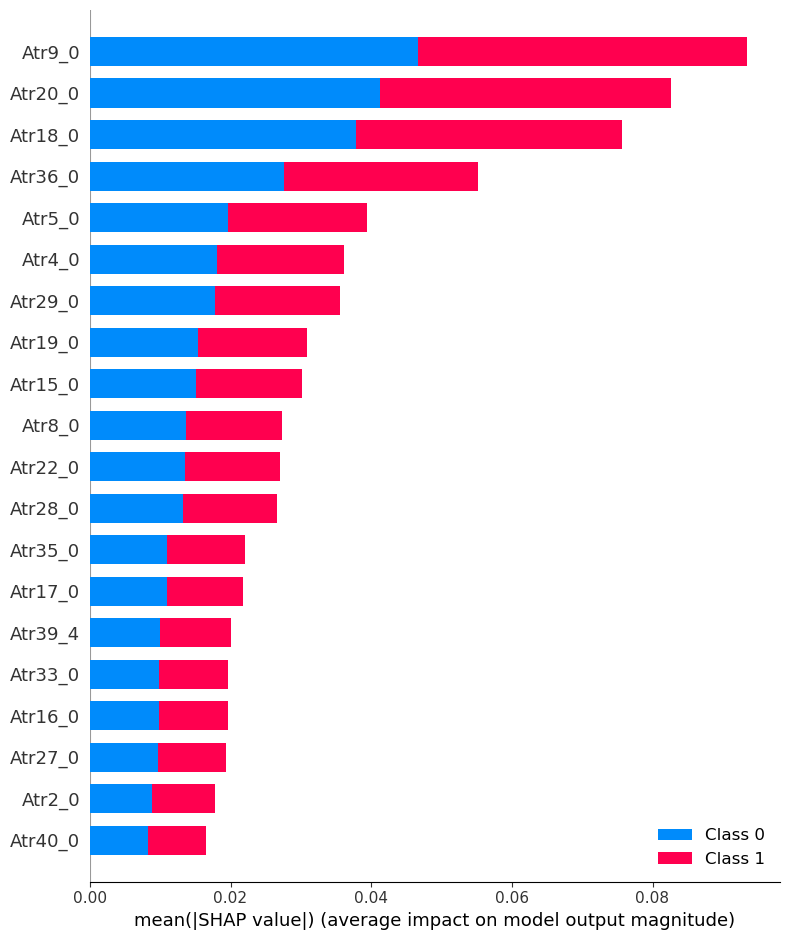

In [19]:
import shap

# Create Tree Explainer object that can calculate shap values
explainer = shap.TreeExplainer(ensemble)

# Evaluate SHAP values
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_train, feature_names=dataset.feature_names)


In [20]:

shap.summary_plot(shap_values, X_train, feature_names=dataset.feature_names, plot_type="dot")

AssertionError: Only plot_type = 'bar' is supported for multi-output explanations!